In [1]:
import nltk

# Download the WordNet corpus
nltk.download("wordnet")

# Download the Open Multilingual Wordnet (often required for newer NLTK versions)
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\legion2025\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\legion2025\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import networkx as nx
from nltk.corpus import wordnet as wn


def graph_synsets(terms, pos=wn.NOUN, depth=2):
    """
    Создает из терминов terms граф networkx с глубиной depth.

    Для каждого определения переберем все синонимы, возвращаемые внутренним методом lemma_names(),
    и добавим узлы и ребра за один шаг вызовом методаG.add_edge() из NetworkX. Если заданный порог
    глубины еще не достигнут,рекурсивно добавим ссылки на термины в синсете.
    После этого функцияgraph_synsets выполнит обход всех терминов и с помощью нашей рекурсивной
    функции add_term_links() извлечет синонимы, сконструирует ребра и, наконец, вернет получившийся граф:
    """
    G = nx.Graph(
        name="WordNet Synsets Graph for {}".format(", ".join(terms)),
        depth=depth,
    )

    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth + 1)

    for term in terms:
        add_term_links(G, term, 0)

    return G


G = graph_synsets(["trinket"])
print(nx.info(G))

Graph named 'WordNet Synsets Graph for trinket' with 25 nodes and 49 edges


C:\Users\legion2025\AppData\Local\Temp\ipykernel_22024\2212196687.py:34: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [23]:
print("Number of nodes", len(G.nodes))
print("Number of edges", len(G.edges))
print("Average degree", sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 25
Number of edges 49
Average degree 3.92


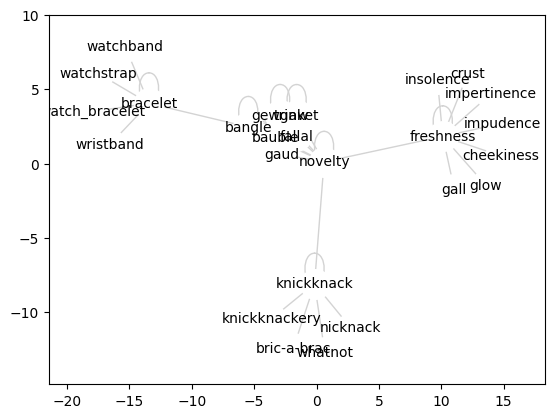

In [24]:
import matplotlib.pyplot as plt


def draw_text_graph(G):
    pos = nx.spring_layout(G, scale=18)
    nx.draw_networkx_nodes(G, pos, node_color="white", linewidths=0, node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color="lightgrey")

    plt.tick_params(
        axis="both",  # изменяются обе оси, X и Y
        which="both",  # затрагиваются большие и малые деления
        bottom="off",  # скрыть деления вдоль нижнего края
        left="off",  # скрыть деления вдоль левого края
        labelbottom="off",  # скрыть подписи вдоль нижнего края
        labelleft="off",
    )  # скрыть подписи вдоль левого края

    plt.show()


draw_text_graph(G)

In [5]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 3.5 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.3 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 4.5 MB/s eta 0:00:03
     ----------- ---------------------------- 3.7/12.8 MB 4.6 MB/s eta 0:00:02
     ------------- -------------------------- 4.5/12.8 MB 4.6 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 4.7 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 4.6 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 4.7 MB/s eta 0:00:02
     --------------------------- ------------ 8.7/12.8 MB 4.7 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 4.8 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 4.8 MB/


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install tabulate==0.9.0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
import networkx as nx
import spacy
import heapq
import itertools
import networkx as nx
from operator import itemgetter
from tabulate import tabulate
from sklearn.pipeline import Pipeline
import heapq
from operator import itemgetter
import os

nlp = spacy.load("en_core_web_sm")

GOOD_ENTS = [
    "PERSON",
    "NORP",
    "FACILITY",
    "ORG",
    "GPE",
    "LOC",
    "PRODUCT",
    "EVENT",
    "WORK_OF_ART",
    "LANGUAGE",
]


def entities(sent):
    doc = nlp(sent)
    # print(list(doc.ents))
    for ent in doc.ents:
        #  filter out non social entities
        if ent.label_ in GOOD_ENTS:
            return ent.text, ent.label_
        else:
            pass


def pairs(doc):
    candidates = [entities(str(sent)) for sent in doc]

    doc_entities = [entity for entity in candidates if entity is not None]

    return list(itertools.permutations(set(doc_entities), 2))


class EntityPairs(BaseEstimator, TransformerMixin):
    def __init__(self):
        super(EntityPairs, self).__init__()

    def pairs(self, document):
        candidates = [entities(str(sent)) for sent in document]
        doc_entities = [entity for entity in candidates if entity is not None]
        return list(itertools.permutations(set(doc_entities), 2))

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        return [self.pairs(document) for document in documents]


class GraphExtractor(BaseEstimator, TransformerMixin):
    """
    Наш класс инициализирует граф NetworkX, а его метод transform перебирает документы
    в корпусе (списки пар сущностей) и проверяет наличие в графе ребра между ними.
    Если ребро существует, его свойство weightувеличивается на 1. Если ребро отсутствует,
    вызовом метода add_edge создается новое ребро с весом 1. По аналогии с конструированием
    графа тезауруса, методadd_edge также добавляет новый узел, если какой-то элемент пары
    отсутствуетв графе:
    """

    def __init__(self):
        self.G = nx.Graph()

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first[0], second[0]) in self.G.edges():
                    self.G.edges[(first[0], second[0])]["weight"] += 1
                else:
                    self.G.add_edge(first[0], second[0], weight=1)
        return self.G


def read_documents(folder_path):
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    data = []

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        # Create full path to the file
        file_path = os.path.join(folder_path, filename)

        # Read the text file
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Pass text to spaCy
        doc = nlp(text)

        # Extract sentences and clean whitespace
        sentences = [sent.text.strip() for sent in doc.sents]

        data.append(sentences)

    return data


def nbest_centrality(G, metrics, n=10):
    """
    В контексте обсуждения сетей наиболее важные узлы занимают центрально место в графе,
    потому что они прямо или косвенно связаны с большинствомузлов. Мера центральности помогает понять связь
    конкретного узла с ближайшими соседями в сети и выявить сущности с наибольшей престижностью и влиянием.
    """

    # Вычисляет оценку центральности для каждой вершины
    nbest = {}
    for name, metric in metrics.items():
        scores = metric(G)

        # Записать оценку в свойство узла
        nx.set_node_attributes(G, name=name, values=scores)

        # Найти n узлов с наивысшей оценкой и вернуть их вместе с индексами
        topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
        nbest[name] = topn

    return nbest


graph = Pipeline(
    [
        ("pairs", EntityPairs()),
        ("graph", GraphExtractor()),
    ]
)

# docs = [list(nlp(sample_text).sents)]
docs = read_documents(
    folder_path="./texts/",
)

G = graph.fit_transform(docs)
centralities = {
    # является мерой популярности, которая определяется как количество соседей данного узла,
    # нормализованное общим количеством узлов в графе.
    "Degree Centrality": nx.degree_centrality,
    # Центральность по степени отражает степень связанности узла и может интерпретироваться как уровень влияния
    # или значимости. В отличие от центральности по степени, отражающей степень связанности узла, центральность
    # по посредничеству (betweenness centrality) показывает, насколько важную роль играет данный узел в связанности графа.
    # Центральность по посредничеству вычисляется как отношение кратчайших путей, пролегающих через данный узел, к общему числу всех
    # кратчайших путей.
    "Betweenness Centrality": nx.betweenness_centrality,
}

centrality = nbest_centrality(G, centralities, 10)

for measure, scores in centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate(scores, headers=["Top Terms", "Score"])))
    print("")
    
# Эти влиятельные и тесно связанные узлы соответствуют сущностям, появляющимся во многих 
# документах, и располагаются на главных «перекрестках

Rankings for Degree Centrality:
Top Terms          Score
--------------  --------
Asia            0.347107
Taiwan          0.214876
Bangkok         0.214876
China           0.214876
Jakarta         0.214876
Roberton        0.214876
Japanese        0.214876
Japan           0.214876
South American  0.214876
Capybaras       0.214876

Rankings for Betweenness Centrality:
Top Terms                 Score
--------------------  ---------
Asia                  0.0573003
EPA                   0.0210744
AU Breaking News      0.0198347
Thai                  0
Rachane Remsringam    0
Flash                 0
Indonesia             0
Anutin Charnvirakul   0
Thailand              0
Amphorn Kaeophengkro  0



In [27]:
for item in G.edges:
    print(item)

('Thai', 'Rachane Remsringam')
('Thai', 'Flash')
('Thai', 'Indonesia')
('Thai', 'Anutin Charnvirakul')
('Thai', 'Asia')
('Thai', 'Thailand')
('Thai', 'Amphorn Kaeophengkro')
('Thai', 'Madam Yong')
('Thai', 'Reuters')
('Thai', 'Sumatra')
('Thai', 'People’s party')
('Thai', 'Hat Yai')
('Thai', 'Malaysia')
('Thai', 'Aceh')
('Thai', 'North Sumatra')
('Thai', 'Narong Sangnak')
('Rachane Remsringam', 'Flash')
('Rachane Remsringam', 'Indonesia')
('Rachane Remsringam', 'Anutin Charnvirakul')
('Rachane Remsringam', 'Asia')
('Rachane Remsringam', 'Thailand')
('Rachane Remsringam', 'Amphorn Kaeophengkro')
('Rachane Remsringam', 'Madam Yong')
('Rachane Remsringam', 'Reuters')
('Rachane Remsringam', 'Sumatra')
('Rachane Remsringam', 'People’s party')
('Rachane Remsringam', 'Hat Yai')
('Rachane Remsringam', 'Malaysia')
('Rachane Remsringam', 'Aceh')
('Rachane Remsringam', 'North Sumatra')
('Rachane Remsringam', 'Narong Sangnak')
('Flash', 'Indonesia')
('Flash', 'Anutin Charnvirakul')
('Flash', 'Asia

In [ ]:
# эго-граф, то есть подграфа, из нашего полного графа, образующего сеть с точки зрения одного конкретного узла.
H = nx.ego_graph(G, "Asia")
hollywood_centralities = {
    "closeness": nx.closeness_centrality,
    "eigenvector": nx.eigenvector_centrality_numpy,
    "katz": nx.katz_centrality_numpy,
    "pagerank": nx.pagerank_numpy,
}

# Центральность по собственному вектору (eigenvector centrality), напротив,говорит о том, что важность узла тем выше, 
# чем больше количество важных узлов, с которыми он связан, то есть выражает «известность по связям». Это означает, 
# что узлы с небольшим количеством очень важных соседей по своей влиятельности могут превосходить узлы с большим 
# количеством связей, соединяющих их с маловажными узлами.

hollywood_centrality = nbest_centrality(H, hollywood_centralities, 10)
for measure, scores in hollywood_centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate(scores, headers=["Top Terms", "Score"])))
    print("")

Rankings for closeness:
Top Terms                 Score
---------------------  --------
Asia                   1
Thomas Peter/Reuters   0.724138
Concerns
Long Wei/FeatureChina  0.724138
Elizabeth Congdon      0.724138
Costa Rica             0.724138
Colombia               0.724138
Roberton               0.724138
Sue Lieberman          0.724138
Japan                  0.724138
Kamakura               0.724138

Rankings for eigenvector:
Top Terms             Score
-----------------  --------
Asia               0.202344
Jakarta            0.191522
Elizabeth Congdon  0.191522
Phoebe Weston      0.191522
Japanese           0.191522
Colombia           0.191522
Japan              0.191522
Kamakura           0.191522
Hangzhou           0.191522
Congdon            0.191522

Rankings for katz:
Top Terms                Score
--------------------  --------
Asia                  0.380439
Reuters               0.212788
Thai                  0.212788
Madam Yong            0.212788
Rachane Remsringam   

c:\Users\legion2025\Desktop\server_apps_volsu_2025\.venv\Lib\site-packages\networkx\algorithms\centrality\katz.py:325: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=nodelist, weight=weight).todense().T
C:\Users\legion2025\AppData\Local\Temp\ipykernel_22024\252731051.py:113: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  scores = metric(G)
c:\Users\legion2025\Desktop\server_apps_volsu_2025\.venv\Lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


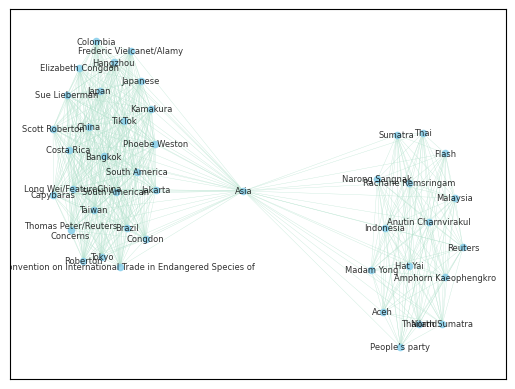

In [29]:
H = nx.ego_graph(G, "Asia")
edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())
pos = nx.spring_layout(H, k=0.3, iterations=40)

nx.draw_networkx(
    H,
    pos,
    node_color="skyblue",
    node_size=20,
    edgelist=edges,
    edge_color=weights,
    width=0.25,
    edge_cmap=plt.cm.Pastel2,
    with_labels=True,
    font_size=6,
    alpha=0.8,
)
plt.show()

C:\Users\legion2025\AppData\Local\Temp\ipykernel_22024\2987634117.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([G.degree(v) for v in G.nodes()], norm_hist=True)


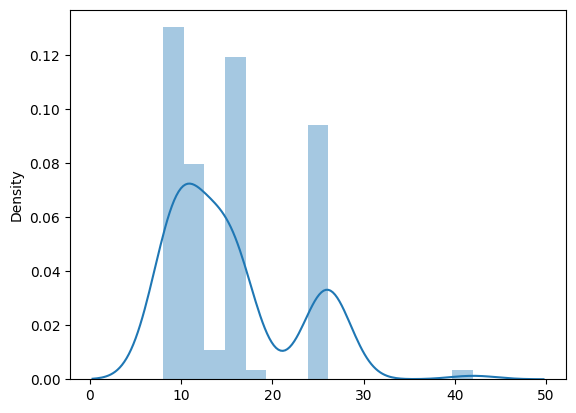

In [13]:
import seaborn as sns

sns.distplot([G.degree(v) for v in G.nodes()], norm_hist=True)
plt.show()

In [ ]:
# Коэффициент кластеризации — это вещественное число, которое принимает значение 0, 
# когда вообще отсутствуют кластеры, и 1, когда граф целиком состоит из не связанных 
# между собой групп (nx.graph_number_of_cliques). Транзитивность определяет 
# вероятность наличия общих соседей у двух узлов:

print("Entity Graph")
print("Average clustering coefficient: {}".format(nx.average_clustering(G)))
print("Transitivity: {}".format(nx.transitivity(G)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(G)))

print("Ego Graph")
print("Average clustering coefficient: {}".format(nx.average_clustering(H)))
print("Transitivity: {}".format(nx.transitivity(H)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(H)))

Entity Graph
Average clustering coefficient: 0.9873607979777276
Transitivity: 0.964546077637236
Number of cliques: 9
Ego Graph
Average clustering coefficient: 0.9887637414580125
Transitivity: 0.9629596652123587
Number of cliques: 2


In [15]:
import networkx as nx
from itertools import combinations
from fuzzywuzzy import fuzz


def pairwise_comparisons(G):
    """
    Создает генератор пар узлов.
    """
    return combinations(G.nodes(), 2)


def edge_blocked_comparisons(G):
    """
    Генератор попарных сравнений, который выявляет вероятно подобные
    узлы, связанные ребрами с одной и той же сущностью.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            yield n1, n2


def similarity(n1, n2):
    """
    Возвращает среднюю оценку подобия, сравнивая поля двух сущностей.
    Обратите внимание, что, если сущности не имеют полей для сопоставления,
    функция вернет ноль.
    """
    # print("n1", n1)
    # print("G.nodes[n1]", G.nodes[n1])
    scores = [
        fuzz.partial_ratio(n1, n2),
        # fuzz.partial_ratio(G.nodes[n1]["type"], G.nodes[n2]["type"]),
        # fuzz.partial_ratio(n1[0], n2[0]),
    ]

    return float(sum(s for s in scores)) / float(len(scores))


def fuzzy_blocked_comparisons(G, threshold=65):
    """
    Генератор попарных сравнений, выявляющий подобные узлы,
    связанные с одной и той же сущностью, но отсекающий пары,
    степень подобия которых ниже заданного порога threshold.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            if similarity(n1, n2) > threshold:
                yield n1, n2


def info(G):
    """
    Обертка для nx.info с несколькими вспомогательными функциями.
    """
    pairwise = len(list(pairwise_comparisons(G)))
    edge_blocked = len(list(edge_blocked_comparisons(G)))
    fuzz_blocked = len(list(fuzzy_blocked_comparisons(G)))

    output = [""]
    output.append("Number of Pairwise Comparisons: {}".format(pairwise))
    output.append("Number of Edge Blocked Comparisons: {}".format(edge_blocked))
    output.append("Number of Fuzzy Blocked Comparisons: {}".format(fuzz_blocked))

    return nx.info(G) + "\n".join(output)


print(info(G))

Graph with 122 nodes and 935 edges
Number of Pairwise Comparisons: 7381
Number of Edge Blocked Comparisons: 1501
Number of Fuzzy Blocked Comparisons: 36


c:\Users\legion2025\Desktop\server_apps_volsu_2025\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
C:\Users\legion2025\AppData\Local\Temp\ipykernel_22024\2927410181.py:69: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  return nx.info(G) + "\n".join(output)


### Итоговый граф

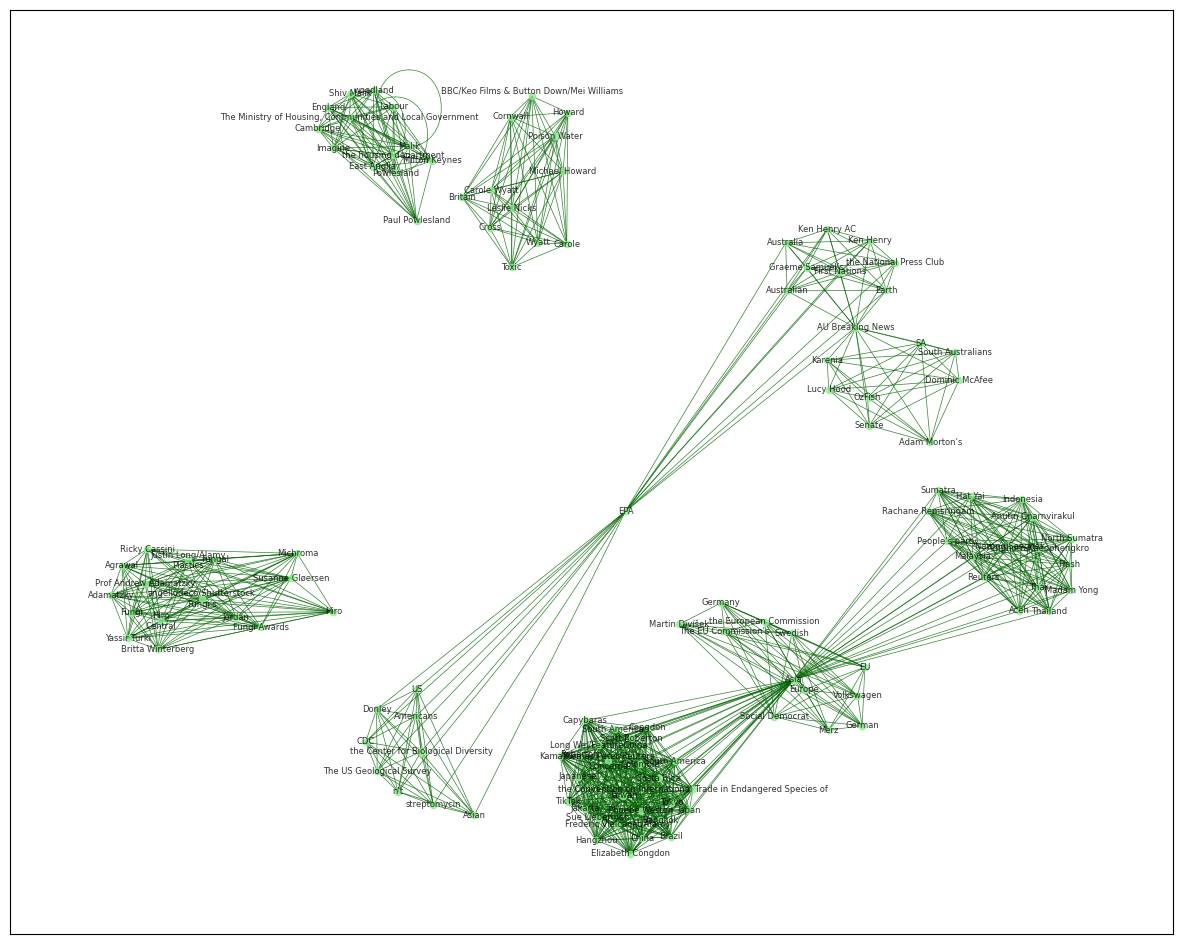

In [34]:
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, k=0.4, iterations=30)
nx.draw_networkx(
    G,
    pos,
    node_color="lightgreen",
    node_size=20,
    edge_color="darkgreen",
    width=0.5,
    with_labels=True,
    font_size=6,
    alpha=0.8,
)
plt.show()

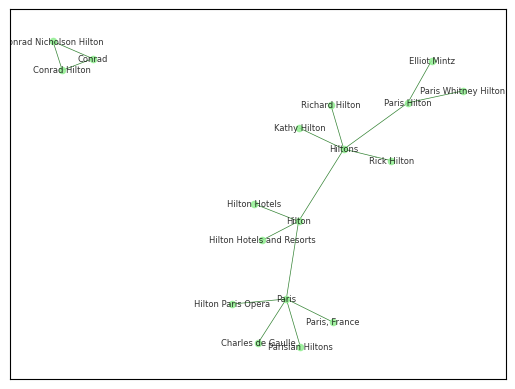

Graph named 'Hilton Family' with 18 nodes and 17 edges
Number of Pairwise Comparisons: 153
Number of Edge Blocked Comparisons: 32
Number of Fuzzy Blocked Comparisons: 20


C:\Users\legion2025\AppData\Local\Temp\ipykernel_22024\1351106857.py:79: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  return nx.info(G) + "\n".join(output)


In [35]:
import networkx as nx
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

from itertools import combinations


def build_graph(edges_and_props, name="Entity Graph"):
    G = nx.Graph(name=name)

    for n1, n2 in edges_and_props:
        G.add_node(n1[0], type=n1[1])
        G.add_node(n2[0], type=n2[1])
        G.add_edge(n1[0], n2[0])

    return G


def pairwise_comparisons(G):
    """
    Produces a generator of pairs of nodes.
    """
    return combinations(G.nodes(), 2)


def edge_blocked_comparisons(G):
    """
    A generator of pairwise comparisons, that highlights comparisons
    between nodes that have an edge to the same entity.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            yield n1, n2


def similarity(n1, n2):
    """
    Returns the mean of the partial_ratio score for each field in the two
    entities. Note that if they don't have fields that match, the score will
    be zero.
    """
    scores = [
        fuzz.partial_ratio(n1, n2),
        fuzz.partial_ratio(G.nodes[n1]["type"], G.nodes[n2]["type"]),
    ]

    return float(sum(s for s in scores)) / float(len(scores))


def fuzzy_blocked_comparisons(G, threshold=65):
    """
    A generator of pairwise comparisons, that highlights comparisons between
    nodes that have an edge to the same entity, but filters out comparisons
    if the similarity of n1 and n2 is below the threshold.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            if similarity(n1, n2) > threshold:
                yield n1, n2


def info(G):
    """
    Wrapper for nx.info with some other helpers.
    """
    pairwise = len(list(pairwise_comparisons(G)))
    edge_blocked = len(list(edge_blocked_comparisons(G)))
    fuzz_blocked = len(list(fuzzy_blocked_comparisons(G)))

    output = [""]
    output.append("Number of Pairwise Comparisons: {}".format(pairwise))
    output.append("Number of Edge Blocked Comparisons: {}".format(edge_blocked))
    output.append("Number of Fuzzy Blocked Comparisons: {}".format(fuzz_blocked))

    return nx.info(G) + "\n".join(output)


if __name__ == "__main__":

    hilton_edges = [
        (("Hilton", "ORG"), ("Hilton Hotels", "ORG")),
        (("Hilton", "ORG"), ("Hilton Hotels and Resorts", "ORG")),
        (("Hilton", "ORG"), ("Hilton Hotels", "ORG")),
        (("Hilton", "ORG"), ("Paris", "GPE")),
        (("Hilton", "ORG"), ("Hiltons", "ORG")),
        (("Paris", "GPE"), ("Charles de Gaulle", "FACILITY")),
        (("Paris", "GPE"), ("Parisian Hiltons", "ORG")),
        (("Paris", "GPE"), ("Hilton Paris Opera", "FACILITY")),
        (("Paris", "GPE"), ("Paris, France", "GPE")),
        (("Hiltons", "ORG"), ("Kathy Hilton", "PERSON")),
        (("Hiltons", "ORG"), ("Richard Hilton", "PERSON")),
        (("Hiltons", "ORG"), ("Rick Hilton", "PERSON")),
        (("Hiltons", "ORG"), ("Paris Hilton", "PERSON")),
        (("Paris Hilton", "PERSON"), ("Paris Whitney Hilton", "PERSON")),
        (("Paris Hilton", "PERSON"), ("Elliot Mintz", "PERSON")),
        (("Conrad Hilton", "PERSON"), ("Conrad", "ORG")),
        (("Conrad Hilton", "PERSON"), ("Conrad Nicholson Hilton", "PERSON")),
        (("Conrad", "ORG"), ("Conrad Nicholson Hilton", "PERSON")),
    ]

    G = build_graph(hilton_edges, name="Hilton Family")

    pos = nx.spring_layout(G, k=0.25, iterations=30)
    nx.draw_networkx(
        G,
        pos,
        node_color="lightgreen",
        node_size=20,
        edge_color="darkgreen",
        width=0.5,
        with_labels=True,
        font_size=6,
        alpha=0.8,
    )
    plt.show()

    print(info(G))